In [1]:
import numpy as np
import pandas as pd
import six, os

from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize
import keras
from keras import layers
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.preprocessing.image import load_img
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D, Dense,GlobalAveragePooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization,Reshape
from tqdm import tqdm_notebook
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.engine import InputSpec
from keras import backend as K
#from keras.applications.imagenet_utils import _obtain_input_shape
from keras.regularizers import l2
from keras import optimizers


from keras.engine.topology import Input
from keras.engine.training import Model
from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers.core import Activation, SpatialDropout2D
from keras.layers.merge import concatenate,add
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D

import tensorflow as tf

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import KFold

/home/lingang/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import time
t_start = time.time()
basic_name = 'RootUnetResnet_version_keyPointDetection'
save_model_name = basic_name + '.model'
submission_file = basic_name + '.csv'

print(save_model_name)
print(submission_file)

img_size_ori = 100
img_size_target = 101

epochs = 75
batch_size = 32

RootUnetResnet_version_keyPointDetection.model
RootUnetResnet_version_keyPointDetection.csv


In [3]:
def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
def upsampleHeatmap(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target, 3))

def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]
#  
def loadImg(imgDir,imgFoldName, img_size_ori = 100 ,channel = 3, gray=True):
    imgs = os.listdir(imgDir+imgFoldName)
    imgNum = len(imgs)
    #data = np.empty((imgNum,img_size_ori,img_size_ori,channel),dtype="float32")
    data = np.empty((imgNum,img_size_ori,img_size_ori),dtype="float32")
    for i in range (imgNum):
        img = load_img(imgDir+imgFoldName+"/"+imgs[i], grayscale=gray)     
        arr = np.asarray(img,dtype="float32") / 255   
        #arr.reshape(img_size_ori,img_size_ori,channel)
        data[i,:,:] = arr
    return data


In [4]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
#         if np.count_nonzero(t) == 0 and np.count_nonzero(p) > 0:
#             metric.append(0)
#             continue
#         if np.count_nonzero(t) >= 1 and np.count_nonzero(p) == 0:
#             metric.append(0)
#             continue
#         if np.count_nonzero(t) == 0 and np.count_nonzero(p) == 0:
#             metric.append(1)
#             continue
        
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred > 0.3], tf.float64)#change 0.5 >> 0.7

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred > 0.1], tf.float64)#change 0.0 >> 0.5

In [5]:
# code download from: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss

In [6]:
#参考https://blog.csdn.net/qq_36289191/article/details/84778229
def __create_pyramid_features(C3, C4, C5, feature_size=256):
    """ Creates the FPN layers on top of the backbone features.
    这里因为是取的由小到大的层作为C3， C4， C5，所以应该将C5缩小放到C4，C4缩小放到C3
    Args
        C3           : Feature stage C3 from the backbone.
        C4           : Feature stage C4 from the backbone.
        C5           : Feature stage C5 from the backbone.
        feature_size : The feature size to use for the resulting feature levels.
    Returns
        A list of feature levels [P3, P4, P5, P6, P7].
    """
    # upsample C5 to get P5 from the FPN paper
    P5           = keras.layers.Conv2D(feature_size, kernel_size=1, strides=1, padding='same', name='C5_reduced')(C5)
    #P5_upsampled = layers.UpsampleLike(name='P5_upsampled')([P5, C4])
    P5_downsampled = layers.AveragePooling2D((2, 2))(P5)
    P5           = keras.layers.Conv2D(feature_size, kernel_size=3, strides=1, padding='same', name='P5')(P5)
 
    # add P5 elementwise to C4
    P4           = keras.layers.Conv2D(feature_size, kernel_size=1, strides=1, padding='same', name='C4_reduced')(C4)
    P4           = keras.layers.Add(name='P4_merged')([P5_downsampled, P4])
    #P4_upsampled = layers.UpsampleLike(name='P4_upsampled')([P4, C3])
    P4_downsampled = layers.AveragePooling2D((2, 2))(P4)
    P4           = keras.layers.Conv2D(feature_size, kernel_size=3, strides=1, padding='same', name='P4')(P4)
 
    # add P4 elementwise to C3
    P3 = keras.layers.Conv2D(feature_size, kernel_size=1, strides=1, padding='same', name='C3_reduced')(C3)
    P3 = keras.layers.Add(name='P3_merged')([P4_downsampled, P3])
    P3 = keras.layers.Conv2D(feature_size, kernel_size=3, strides=1, padding='same', name='P3')(P3)
 
    return [P3, P4, P5]


In [7]:
model = load_model('RootUnetResnet_version_1.model',custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                   'lovasz_loss': lovasz_loss})
for layer in model.layers:
    layer.name = layer.name + str("_origin")
    print(layer.name)

input_1_origin
conv2d_37_origin
batch_normalization_34_origin
activation_34_origin
conv2d_38_origin
batch_normalization_35_origin
activation_35_origin
conv2d_39_origin
global_average_pooling2d_1_origin
dense_1_origin
dense_2_origin
reshape_1_origin
multiply_1_origin
add_17_origin
batch_normalization_36_origin
activation_36_origin
conv2d_40_origin
batch_normalization_37_origin
activation_37_origin
conv2d_41_origin
global_average_pooling2d_2_origin
dense_3_origin
dense_4_origin
reshape_2_origin
multiply_2_origin
add_18_origin
batch_normalization_38_origin
activation_38_origin
max_pooling2d_2_origin
dropout_1_origin
conv2d_42_origin
batch_normalization_39_origin
activation_39_origin
conv2d_43_origin
batch_normalization_40_origin
activation_40_origin
conv2d_44_origin
global_average_pooling2d_3_origin
dense_5_origin
dense_6_origin
reshape_3_origin
multiply_3_origin
add_19_origin
batch_normalization_41_origin
activation_41_origin
conv2d_45_origin
batch_normalization_42_origin
activation_42_o

In [8]:
C3 = model.get_layer('activation_68_origin').output #25*25 203层
C4 = model.get_layer('activation_73_origin').output #50*50 233层
C5 = model.get_layer('activation_78_origin').output #101*101 263层
#冻结层
# for layer in model.layers:
#     layer.trainable = False
    
P3, P4, P5 = __create_pyramid_features(C3, C4, C5, feature_size= 32)

D3 =  Conv2D(16, (3,3), activation=None, padding="same")(P3)
D3 =  Conv2D(16, (3,3), activation=None, padding="same")(D3)
D3 =  UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest')(D3)
D3 = Conv2DTranspose(16, (3,3), strides=(2, 2), padding="valid")(D3)

D4 =  Conv2D(16, (3,3), activation=None, padding="same")(P4)
D4 =  Conv2D(16, (3,3), activation=None, padding="same")(D4)
D4 = Conv2DTranspose(16, (3,3), strides=(2, 2), padding="valid")(D4)

D5 =  Conv2D(16, (3,3), activation=None, padding="same")(P5)
D5 =  Conv2D(16, (3,3), activation=None, padding="same")(D5)

conc = concatenate([D3, D4, D5] )
conv = Conv2D(16*3, (3,3), activation="relu", padding="same")(conc)
output_layer_noActi = Conv2D(3, (1,1), padding="same")(conv)
output = Activation('sigmoid')(output_layer_noActi)#sigmoid激活函数应用于多标签分类(这里看作多标签，因为背景不考虑)，softmax激活函数应用于多类分类

keyPointModel = Model(inputs=model.input, outputs=output)

# for layer in keyPointModel.layers:
#     print(layer.name, layer.trainable)

In [9]:
import warnings

warnings.filterwarnings('ignore')
##load data
train_df = pd.DataFrame()  
imgs = os.listdir("./trainKeypoint/image")
imgNum = len(imgs)
train_df["images"] = [np.array(load_img("./trainKeypoint/"+"image"+"/"+imgs[i], grayscale=True)) / 255 for i in range (imgNum)]
train_df["masks"] = [np.array(load_img("./trainKeypoint/"+"mask"+"/"+imgs[i], grayscale=True)) / 255 for i in range (imgNum)]
train_df["heatmaps"] = [upsampleHeatmap(np.array(load_img("./trainKeypoint/"+"heatMap"+"/"+imgs[i] )))  for i in range (imgNum)]#已经在0-1范围
#train_img = loadImg("./train/","image")
#train_mask = loadImg("./train/","mask",channel = 1, gray=True)
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)
coverageMax = train_df["coverage"].max()

In [10]:
def cov_to_class(val):    
    for i in range(0, 11):
        if (val/coverageMax/2) * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

x_data = np.array(train_df.images.map(upsample).tolist()).reshape(-1,img_size_target, img_size_target, 1)
y_data = np.array(train_df.heatmaps.tolist())

ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test = train_test_split(
    train_df.index.values,
    x_data, 
    y_data, 
    train_df.coverage.values,
    test_size = 0.05 , stratify=train_df.coverage_class, random_state=42)

x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

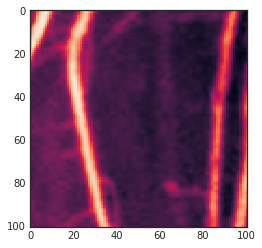

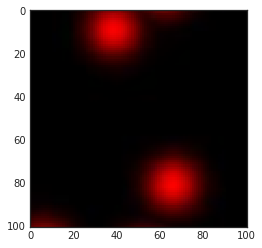

In [11]:
index = 335
img = x_data[index].reshape(img_size_target, img_size_target)
plt.imshow(img, interpolation='nearest')
plt.show()
#彩图范围0-1
img = y_data[index]#y_train[0]
plt.imshow(img, interpolation='nearest')
plt.show()

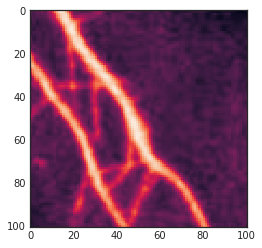

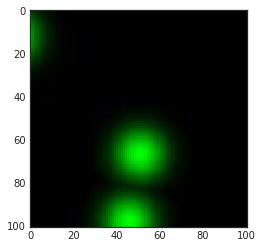

In [12]:
index = 56
img = x_train[index].reshape(img_size_target, img_size_target)
plt.imshow(img, interpolation='nearest')
plt.show()
#彩图范围0-1
img = y_train[index]#y_train[0]
plt.imshow(img, interpolation='nearest')
plt.show()

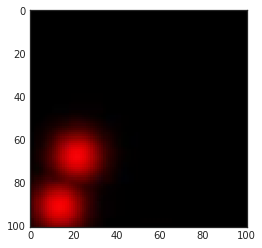

In [13]:
img = upsampleHeatmap(np.array(load_img("./trainKeypoint/"+"heatMap"+"/"+imgs[0] ))).reshape( img_size_target, img_size_target, 3)
plt.imshow(img, interpolation='nearest')
plt.show()

In [14]:
keyPointModel.compile(optimizer=optimizers.Adam(lr=0.001), loss='mean_squared_error')

In [15]:
#early_stopping = EarlyStopping(monitor='my_iou_metric', mode = 'max',patience=10, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_name,monitor='loss', 
                                   mode = 'min', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='loss', mode = 'min',factor=0.5, patience=5, min_lr=0.0001, verbose=1)

history = keyPointModel.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[ model_checkpoint,reduce_lr], 
                    verbose=1)

Train on 7622 samples, validate on 201 samples
Epoch 1/75
7622/7622 [==============================] - 76s 10ms/step - loss: 0.0120 - val_loss: 0.0103

Epoch 00001: loss improved from inf to 0.01199, saving model to RootUnetResnet_version_keyPointDetection.model
Epoch 2/75
7622/7622 [==============================] - 57s 7ms/step - loss: 0.0098 - val_loss: 0.0086

Epoch 00002: loss improved from 0.01199 to 0.00985, saving model to RootUnetResnet_version_keyPointDetection.model
Epoch 3/75
7622/7622 [==============================] - 57s 7ms/step - loss: 0.0078 - val_loss: 0.0074

Epoch 00003: loss improved from 0.00985 to 0.00781, saving model to RootUnetResnet_version_keyPointDetection.model
Epoch 4/75
7622/7622 [==============================] - 57s 8ms/step - loss: 0.0072 - val_loss: 0.0073

Epoch 00004: loss improved from 0.00781 to 0.00716, saving model to RootUnetResnet_version_keyPointDetection.model
Epoch 5/75
7622/7622 [==============================] - 57s 8ms/step - loss: 0.0

7622/7622 [==============================] - 55s 7ms/step - loss: 0.0047 - val_loss: 0.0053

Epoch 00039: loss improved from 0.00479 to 0.00474, saving model to RootUnetResnet_version_keyPointDetection.model
Epoch 40/75
7622/7622 [==============================] - 56s 7ms/step - loss: 0.0047 - val_loss: 0.0053

Epoch 00040: loss improved from 0.00474 to 0.00472, saving model to RootUnetResnet_version_keyPointDetection.model
Epoch 41/75
7622/7622 [==============================] - 55s 7ms/step - loss: 0.0047 - val_loss: 0.0053

Epoch 00041: loss improved from 0.00472 to 0.00471, saving model to RootUnetResnet_version_keyPointDetection.model
Epoch 42/75
7622/7622 [==============================] - 55s 7ms/step - loss: 0.0047 - val_loss: 0.0056

Epoch 00042: loss improved from 0.00471 to 0.00466, saving model to RootUnetResnet_version_keyPointDetection.model
Epoch 43/75
7622/7622 [==============================] - 55s 7ms/step - loss: 0.0046 - val_loss: 0.0053

Epoch 00043: loss improved 

In [16]:
model = load_model(save_model_name)


In [17]:
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    print(x_test_reflect.shape)
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target,3)
    print(preds_test.shape)
    preds_test2_refect = model.predict(x_test_reflect).reshape(-1, img_size_target, img_size_target,3)
    print(preds_test2_refect.shape)
    preds_test += np.array([ np.fliplr(x) for x in preds_test2_refect] )
    return preds_test/2

In [18]:
##load data 
imgs_test = os.listdir("./test/image")
imgNum_test = len(imgs_test)

x_test_df = pd.DataFrame() 
#x_test_df["img"] = [images_test]
#
x_test_df["images"] = [(np.array(load_img("./test/"+"image"+"/"+imgs_test[i], grayscale=True))) / 255 for i in range (imgNum_test)]
x_test = np.array(x_test_df.images.map(upsample).tolist()).reshape(-1,img_size_target, img_size_target, 1)

In [19]:
x_test.shape


(352, 101, 101, 1)

In [20]:
t1 = time.time()
preds_test = predict_result(keyPointModel,x_test,img_size_target)
# pred_dict = np.array([np.round(downsample(preds_test[i]) > threshold_best) for i in range (imgNum_test)])
t2 = time.time()

print(f"Usedtime = {t2-t1} s")

(352, 101, 101, 1)
(352, 101, 101, 3)
(352, 101, 101, 3)
Usedtime = 4.3704798221588135 s


In [21]:
import scipy.misc
for i in range (imgNum_test):
    scipy.misc.imsave("./test/"+"heatmap"+"/"+imgs_test[i], preds_test[i])#应该下采样到100*100再存，这里忘了

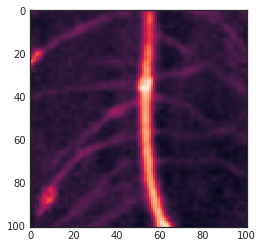

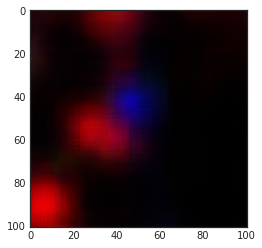

In [23]:
img = x_test[3].reshape(img_size_target, img_size_target)
plt.imshow(img, interpolation='nearest')
plt.show()
img = preds_test[3]
plt.imshow(img, interpolation='nearest')
plt.show()